### Chapter 5.5 
# Model with Batch Service and Threshold Control: M/GI$^{[\Theta,K]}$/1-S 

---
>(c) Tobias Hossfeld  (Aug 2021)<br><br>
> This script and the figures are part of the following book. The book is to be cited whenever the script is used (copyright CC BY-SA 4.0):<br>
> *Tran-Gia, P. & Hossfeld, T. (2021). 
Performance Modeling and Analysis of Communication Networks - A Lecture Note.
Würzburg University Press.*
> *https://doi.org/10.25972/WUP-978-3-95826-153-2*

---

We consider now a model with batch service and threshold control: M/GI$^{[\Theta,K]}$/1-S 
A work station processes a batch of jobs jointly (*batch service*). At most $K$ jobs can be processed during batch service. However, the work station is first activated if there are enough jobs available to be processed (*threshold control*). This threshold $\Theta$ when to activate the service controls the efficiency of the system as well as the wait and response time for jobs. For manufacturing systems, it may be more cost-efficient to run the machine for a minimum number $\Theta$ of jobs, while the processing capacity $K$ as well as the waiting space $S$ are limited. The system can still be analyzed using the embedded Markov chain technique.

## Example: Definition of Parameters

In [1]:
# Definition der Parameter
Theta = 3 # threshold control
K = 8     # maximum batch size 
S = 10    # number of waiting places
cB = 0    # coefficient of variation of the service time
rho = 0.9 # normalized offered load

EB = 1.0            # mean service time
mu = 1.0 / EB       # service rate
lam = rho * K / EB  # arrival rate
epsilon = 1e-16     # power method: accuracy when to stop iterations when comparing means

## Random Variable $\Gamma$ 
The random variable $\Gamma$ reflects the number of Poisson arrivals during the service time $B$. As defined in Chapter 3.3.3 "Poisson Arrivals during an Arbitrarily Distributed Interval", it is

$ \Gamma_{GF} (z) = \Phi_B \Big(\lambda (1 - z)\Big) $.

We compute the probability $\gamma(i)=P(\Gamma=i)$ by numerical integration:

 $\gamma(i) = \int\limits_{0}^\infty P(\Gamma=i\,|\,B=\tau)
     {b(\tau) \;d\tau}       
     = \int\limits_{0}^\infty \frac{(\lambda\tau)^i}{i!}
     e^{-\lambda\tau} b(\tau) \;d\tau $
     
Depending on the coefficient of variation $c_B$, we use different distributions for the service time $B$: 
* $c_B=0$: deterministic distribution
* $c_B=1$: exponential distribution
* otherwise: lognormal distribution

In [2]:
import numpy as np
from scipy.stats import lognorm, poisson 
from scipy.integrate import quad

if cB==1: # exponential distribution
    if False:
        gamma_i = np.zeros(S)
        for i in np.arange(S):
            integrand = lambda t: pdf_b(t)*poisson.pmf(i, lam*t)
            gamma_i[i] = quad(integrand, 0, np.inf)[0]
        gamma_i[S] = 1-gamma_i[:-1].sum()
    else:
        i = np.arange(S)            
        gamma_i = (lam*EB)**i/(1+lam*EB)**(i+1)        
elif cB==0: # deterministic distribution
    gamma_i = np.zeros(S)
    i = np.arange(S)           
    gamma_i[i] = poisson.pmf(i, lam*EB)            
else: # lognormal distribution
    std = EB*cB
    m = EB
    v = std**2
    phi = np.sqrt(v + m**2);
    #mulogn    = np.log(m**2/phi);          
    sigma = np.sqrt(np.log(phi**2/m**2));         
    mymu = np.log(m)
    scale = np.exp(mymu-(sigma**2)/2)    
    shape = sigma    

    pdf_b = lambda t: lognorm.pdf(t, s=shape, scale=scale, loc=0)    
    cdf_b = lambda t: lognorm.cdf(t, s=shape, scale=scale, loc=0)    
    
    gamma_i = np.zeros(S+1)
    for i in np.arange(S):
        integrand = lambda t: pdf_b(t)*poisson.pmf(i, lam*t)
        gamma_i[i] = quad(integrand, 0, np.inf)[0]

## State Transition matrix $P = \{p_{ij}\}$
The state transition matrix is defined in Chapter 5.5.2 and implemented here.


          0         1         2         3         4         5         6   \
0   0.000747  0.005375  0.019352  0.046444  0.083598  0.120382  0.144458   
1   0.000747  0.005375  0.019352  0.046444  0.083598  0.120382  0.144458   
2   0.000747  0.005375  0.019352  0.046444  0.083598  0.120382  0.144458   
3   0.000747  0.005375  0.019352  0.046444  0.083598  0.120382  0.144458   
4   0.000747  0.005375  0.019352  0.046444  0.083598  0.120382  0.144458   
5   0.000747  0.005375  0.019352  0.046444  0.083598  0.120382  0.144458   
6   0.000747  0.005375  0.019352  0.046444  0.083598  0.120382  0.144458   
7   0.000747  0.005375  0.019352  0.046444  0.083598  0.120382  0.144458   
8   0.000747  0.005375  0.019352  0.046444  0.083598  0.120382  0.144458   
9   0.000000  0.000747  0.005375  0.019352  0.046444  0.083598  0.120382   
10  0.000000  0.000000  0.000747  0.005375  0.019352  0.046444  0.083598   

          7         8         9         10  
0   0.148586  0.133727  0.106982  0.190350

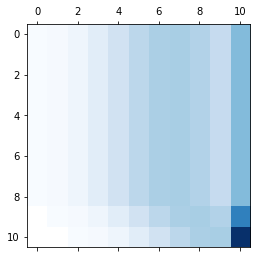

In [3]:
P = np.zeros((S+1,S+1))
for row in np.arange(len(P)):    
    for col in np.arange(S+1):
        if col==S:
            P[row,col] = 1-np.sum(P[row,:col])            
        else:
            if row<=K:                
                P[row,col] = gamma_i[col]
            else: # row >= K+1
                offset = row-K
                if col<offset:
                    P[row,col] = 0
                else:
                    P[row,col] = gamma_i[col-offset]    


import pandas as pd
import matplotlib.pyplot as plt

# Visualisierung der Ratenmatrix
def printMatrix(Q):
    print(pd.DataFrame(Q)) # pretty display of the matrix using Pandas    
    Q2 = Q.copy()
    Q2[Q==0]=np.nan
    plt.matshow(Q2,fignum=4, cmap='Blues')   
    
printMatrix(P)      
    

## Power Method

A simple implementation of the power method with the start condition $ X_0 $ and transition matrix $ P $. The accuracy of the power method is achieved by comparing the expected values with accuracy $ \epsilon = 1e-16 $.

We get the steady state probabilities $ X $ at the embedding times.

           X
0   0.000456
1   0.003374
2   0.012673
3   0.032158
4   0.061884
5   0.096117
6   0.125238
7   0.140532
8   0.138404
9   0.121369
10  0.267795


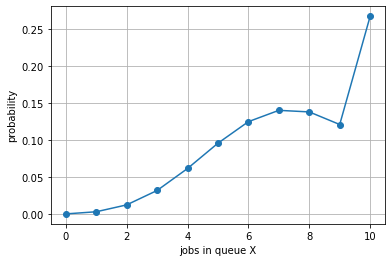

In [4]:
def powerMethod(X0, P, epsilon):    
    X_old = np.zeros(S+1)
    X1 = X0.copy()        
    num = 0
    EX_old = 0
    EX1 = 0
    while  ( abs(EX_old-EX1) > epsilon ) or (num<5): # at least 5 iterations        
        X_old = X1.copy()
        X1 = X_old @ P # matrix mulitplication        
        num +=1            
        EX_old = X_old @ np.arange(S+1)  # first moment
        EX1 = X1 @ np.arange(S+1)        
    return X1, num

X0 = np.zeros(S+1)
X0[0] = 1
X, num =  powerMethod(X0, P, epsilon)

print(pd.DataFrame({"X": X}))
plt.plot(X, 'o-')
plt.xlabel('jobs in queue X')
plt.grid(which='major')
plt.ylabel('probability');

## State Probabilities at Arbitrary Times
The power method returns the steady state probabilities at the embedding times. We are however interested in the state probabilities $x^*(i)$ at arbitrary times. Due to the PASTA property, it is $x^*(i)=x_A(i)$ for arriving customers.

We define the random variable $X^*_y(i) = P(X^*=i, Y=y)$ with $X^*$ reflecting the number of customers in the waiting queue at an arbitrary time, while $Y$ indicates if the server is active and serving a batch of customers ($Y=1$) or if the server is idle ($Y=0$). The steady state probabilities are then as follows. 

$
 x^*_0(i) = \frac{\sum_{j=0}^i x(j)}{\lambda E[B] + \sum_{k=0}^i (\Theta-i)x(k) } , \quad 0 \leq i \leq \Theta-1 \\
 x^*_1(i) = \frac{\sum_{j=i+1}^{\min(K+i,S)} x(j)}{\lambda E[B] + \sum_{k=0}^i (\Theta-i)x(k) } , \quad 0 \leq i \leq S-1 \\
 x^*_1(S) = 1 - \sum_{i=0}^{\Theta-1} x^*_0(i) - \sum_{i=0}^{S-1} x^*_1(i)
$


Further system characteristics are obtained from the probabilities in vector $\vec{X}^{\ast}$. The blocking probability is

$
p_B = x^{\ast} (S) \;.
$

The mean waiting time in the system is

$
E[W]  =  \frac{E[X^*]}{\lambda  (1-p_B)}  \quad \mbox{with}\quad\quad
E[X^*] = \sum\limits_{k=0}^S k \cdot  x^{\ast} (k) \;.
$


In the implementation we have the following variables:
* $x^*_0(i)$ : `Pn0`
* $x^*_1(i)$ : `Pn1`
* $x^*(i)$ : `Pn`

mean waiting time E[W]: 0.6151
blocking probability pB: 0.0541

steady state probabilities at arbitrary times
          X*
0   0.084594
1   0.101402
2   0.138489
3   0.131750
4   0.123180
5   0.109869
6   0.092524
7   0.073062
8   0.053895
9   0.037087
10  0.054148


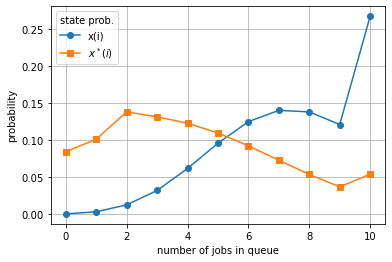

In [5]:

Pn0 = np.zeros(Theta)
i = np.arange(Theta)
nenner = lam*EB + ((Theta-i)*X[i]).sum()
for n in np.arange(Theta):
    Pn0[n] = X[:n+1].sum()/nenner

Pn1 = np.zeros(S+1)
for n in np.arange(S):
    bound = min(K+n,S)
    Pn1[n] = X[n+1:bound+1].sum()/nenner

Pn1[S] = 1 - Pn0.sum() - Pn1.sum()

Pn = Pn1.copy()
Pn[:Theta] += Pn0    

#%%
pB = Pn[S]
EXstar = Pn @ np.arange(S+1)
EW = EXstar/(lam*(1-pB))   
print(f'mean waiting time E[W]: {EW:.4f}')
print(f'blocking probability pB: {pB:.4f}')
print('\nsteady state probabilities at arbitrary times')
print(pd.DataFrame({"X*": Pn}))

plt.plot(X,'o-', label='x(i)')
plt.plot(Pn,'s-', label='$x^*(i)$')

plt.xlabel('number of jobs in queue')
plt.ylabel('probability')
plt.grid(which='major')
plt.legend(title='state prob.');